Welcome to the hands-on lab for **Integrating Unit Test Automation**. In this lab, you will take the cloned code from the previous pipeline step and run linting and unit tests against it to ensure it is ready to be built and deployed.

# Learning Objectives

After completing this lab, you will be able to:
* Use the Tekton CD catalog to install the flake8 task
* Describe the parameters required to use the flake8 task
* Use the flake8 task in a Tekton pipeline to lint your code
* Create a test task from scratch and use it in your pipeline

# Set Up the Lab Environment

## Clone the Code Repo

Now, get the code that you need to test. 

To do this, use the `git clone` command to clone the Git repository:
```
git clone https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git
```

**Your output should look similar to the image below:**

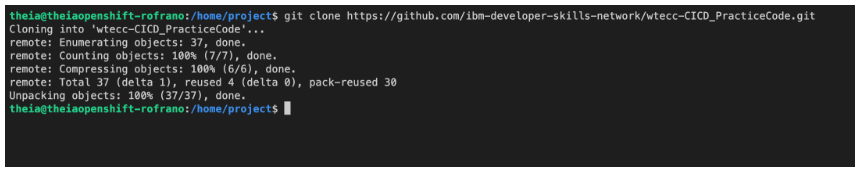


## Change to the Labs Directory

Once you have cloned the repository, change to the labs directory.
```
cd wtecc-CICD_PracticeCode/labs/04_unit_test_automation/
```

## Navigate to the Labs Folder

Navigate to the `labs/04_unit_test_automation` folder in the left explorer panel. 

All of your work will be with the files in this folder.

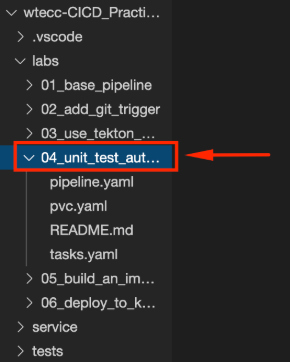

You are now ready to continue installing the **Prerequisites**.

# Prerequisites

This lab requires installation of the tasks introduced in previous labs. To be sure, apply the previous tasks to your cluster before proceeding. Reissuing these commands will not hurt anything.

## Establish the Tasks

```
kubectl apply -f tasks.yaml
tkn hub install task git-clone
```

**Note:** *If the above command for installing git-clone task returns a error due to Tekton Version mismatch, please run the below command to fix this.*
```
kubectl apply -f https://raw.githubusercontent.com/tektoncd/catalog/main/task/git-clone/0.9/git-clone.yaml
```
**Check that you have all of the previous tasks installed:**
```
tkn task ls
```

**You should see the output similar to this:**

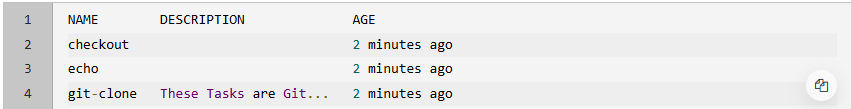


## Establish the Workspace

You also need a **PersistentVolumeClaim** (PVC) to use as a workspace. 

Apply the following `pvc.yaml` file to establish the PVC: `kubectl apply -f pvc.yaml`

You should see the following output:
```
persistentvolumeclaim/pipelinerun-pvc created
```
> *Note: if the **PVC** already exists, the output will say **unchanged** instead of **created**. This is fine.*

You can now reference this persistent volume claim by its name `pipelinerun-pvc` when creating workspaces for your Tekton tasks.

You are now ready to continue with this lab.

# Step 0: Check for cleanup

Please check as part of **Step 0** for the new `cleanup` task which has been added to `tasks.yaml` file.

When a task that causes a compilation of the Python code, it leaves behind .pyc files that are owned by the specific user. For consecutive pipeline runs, the git-clone task tries to empty the directory but needs privileges to remove these files and this `cleanup` task takes care of that.

The `init` task is added `pipeline.yaml` file which runs everytime before the `clone` task.

Check the `tasks.yaml` file which has the new `cleanup` task updated.

## Check the updated cleanup task

```
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: cleanup
spec:
  description: This task will clean up a workspace by deleting all of the files.
  workspaces:
    - name: source
  steps:
    - name: remove
      image: alpine:3
      env:
        - name: WORKSPACE_SOURCE_PATH
          value: $(workspaces.source.path)
      workingDir: $(workspaces.source.path)
      securityContext:
        runAsNonRoot: false
        runAsUser: 0
      script: |
        #!/usr/bin/env sh
        set -eu
        echo "Removing all files from ${WORKSPACE_SOURCE_PATH} ..."
        # Delete any existing contents of the directory if it exists.
        #
        # We don't just "rm -rf ${WORKSPACE_SOURCE_PATH}" because ${WORKSPACE_SOURCE_PATH} might be "/"
        # or the root of a mounted volume.
        if [ -d "${WORKSPACE_SOURCE_PATH}" ] ; then
          # Delete non-hidden files and directories
          rm -rf "${WORKSPACE_SOURCE_PATH:?}"/*
          # Delete files and directories starting with . but excluding ..
          rm -rf "${WORKSPACE_SOURCE_PATH}"/.[!.]*
          # Delete files and directories starting with .. plus any other character
          rm -rf "${WORKSPACE_SOURCE_PATH}"/..?*
        fi
```

**Check the `pipeline.yaml` file which is updated with `init` that uses the `cleanup` task.**

## Check the updated init task

```
tasks:
    - name: init
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: cleanup
```

# Step 1: Add the flake8 Task

Your pipeline has a placeholder for a `lint` step that uses the `echo` task. Now it is time to replace it with a real linter.

You are going to use `flake8` to `lint` your code. Luckily, Tekton Hub has a flake8 task that you can install and use:

Use the following **Tekton CLI** command to install the `flake8` task into your namespace.
```
tkn hub install task flake8
```

This will install the `flake8` task in your Kubernetes namespace.

You should see output similar to this:
```
Task flake8(0.1) installed in sn-labs-rofrano namespace
```
> *Note: Your Kubernetes namespace will be listed.*

# Step 2: Modify the Pipeline to Use flake8

Now you will modify the `pipeline.yaml` file to use the new `flake8` task.

In reading the documentation for the flake8 task, you notice that it requires a workspace named `source`. Add the workspace to the lint task after the `name:`, but before the `taskRef:`.

## Your Task

Scroll down to the `lint` task.

Add the `workspaces:` keyword to the lint task after the task `name:` but before the `taskRef:`.

Specify the workspace `name:` as `source`.

Specify the `workspace:` reference as `pipeline-workspace`, which was created in the previous lab.
```
    - name: lint
      workspaces:
        - name: {name of workspace goes here}
          workspace: {workspace reference goes here}
      taskRef:
      ...
```

Change the `taskRef:` from `echo` to reference the `flake8` task.
```
    - name: lint
      ...
      taskRef:
        name: {task reference to flake}
```

Check that your new edits match the solution up to this point.

## Solution

```
    - name: lint
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: flake8
```

Next, you will modify the parameters passed into the task.

# Step 3: Modify the Parameters for flake8

Now that you have added the workspace and changed the task reference to **flake8**, you need to modify the `pipeline.yaml` file to change the parameters to what flake8 is expecting.

In reading the documentation for the flake8 task, you see that it accepts an optional `image` parameter that allows you to specify your own container image. Since you are developing in a **Python 3.9-slim container**, you want to use `python:3.9-slim` as the image.

The flake8 task also allows you to specify arguments to pass to flake8 using the `args` parameter. These arguments are specified as a list of strings where each string is a parameter passed to flake8. For example, the arguments `--count --statistics` would be specified as: `["--count", "--statistics"]`.

Edit the `pipeline.yaml` file.

## Your Task

1. Change the `message` parameter to the `image` parameter to specify the value of `python:3.9-slim`.
2. Add a new parameter called `args` to specify the arguments as a list `[]` with the values `--count --max-complexity=10 --max-line-length=127 --statistics` to pass to `flake8`.

> *The documentation tells you that this must be passed as a list, so be sure to pass each argument as a separate string in the list, delimited by commas.*

## Solution

```
    - name: lint
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: flake8
      params:
      - name: image
        value: "python:3.9-slim"
      - name: args
        value: ["--count","--max-complexity=10","--max-line-length=127","--statistics"]
      runAfter:
        - clone

    # Note: The remaining tasks are unchanged
```

**Apply these changes to your cluster:** `kubectl apply -f pipeline.yaml`

You should see the following output:
```
pipeline.tekton.dev/cd-pipeline configured
```

# Step 4: Run the Pipeline

You are now ready to run the pipeline and see if your new lint task is working properly. You will use the Tekton CLI to do this.

Start the pipeline using the following command:
```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch="main" \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

You should see the pipeline run complete successfully. If you see errors, go back and check your work against the solutions provided.

# Step 5: Create a Test Task

Your pipeline also has a placeholder for a `tests` task that uses the `echo` task. Now you will replace it with real unit tests. In this step, you will replace the `echo` task with a call to a unit test framework called `nosetests`.

There are no tasks in the Tekton Hub for `nosetests`, so you will write your own.

Update the `tasks.yaml` file adding a new task called `nose` that uses the shared workspace for the pipeline and runs `nosetests` in a `python:3.9-slim` image as a shell script as seen in the course video.

Here is a bash script to install the Python requirements and run the nosetests. You can use this as the shell script in your new task:
```
#!/bin/bash
set -e
python -m pip install --upgrade pip wheel
pip install -r requirements.txt
nosetests -v --with-spec --spec-color
```


## Your Task

1. Create a new task in the `tasks.yaml` file and name it `nose`. Remember, each new task must be separated using three dashes `---` on a separate line.

2. Next, you need to include the workspace that has the code that you want to test. Since flake8 uses the name `source`, you can use that for consistency. Add a workspace named `source`.

3. It might be a good idea to allow the passing in of different arguments to `nosetests`, so create a parameter called `arg`s just like the `flake8` task has, and give it a `description`:, make the `type:` a string, and a `default:` with the verbose flag **“-v”** as the default.

4. Finally, you need to specify the steps, and there is only one. Give it the name `nosetests`.

5. Have it run in a `python:3.9-slim` image.

6. Also, specify `workingDir` as the path to the workspace you defined (i.e., `$(workspaces.source.path)`).

7. Then, paste the script from above in the script parameter.

Double-check that your work matches the solution below.

# Solution

```
---
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: nose
spec:
  workspaces:
    - name: source
  params:
    - name: args
      description: Arguments to pass to nose
      type: string
      default: "-v"
  steps:
    - name: nosetests
      image: python:3.9-slim
      workingDir: $(workspaces.source.path)
      script: |
        #!/bin/bash
        set -e
        python -m pip install --upgrade pip wheel
        pip install -r requirements.txt
        nosetests $(params.args)
```

**Apply these changes to your cluster:** `kubectl apply -f tasks.yaml`

**You should see the following output:**
```
task.tekton.dev/echo configured
task.tekton.dev/cleanup configured
task.tekton.dev/nose created
```

# Step 6: Modify the Pipeline to Use nose

The final step is to use the new `nose` task in your existing pipeline in place of the `echo` task placeholder.

Edit the `pipeline.yaml` file.

Add the workspace to the `tests` task after the name but before the `taskRef:`, change the `taskRef` to reference your new `nose` task, and change the `message` parameter to pass in your new `args` parameter.

## Your Task

Scroll down to the `tests` task definition.

1. Add a workspace named `source` that references `pipeline-workspace` to the `tests` task after the `name:` but before the `taskRef:`.

2. Change the `taskRef:` from `echo` to reference your new `nose` task.

3. Change the `message` parameter to the `args` parameter and specify the arguments to pass to the tests as `-v --with-spec --spec-color`.

Double-check that your work matches the solution below.

# Solution

```
    - name: tests
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: nose
      params:
      - name: args
        value: "-v --with-spec --spec-color"
      runAfter:
        - lint
```

**Apply these changes to your cluster:** `kubectl apply -f pipeline.yaml`

**You should see the following output:**
```
pipeline.tekton.dev/cd-pipeline configured
```

# Step 7: Run the Pipeline Again

Now that you have your `tests` task complete, run the pipeline again using the Tekton CLI to see your new test tasks run:
```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch="main" \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

**You can see the pipeline run status by listing the `PipelineRun` with:** `tkn pipelinerun ls`

**You should see:**

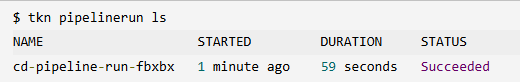

**You can check the logs of the last run with:** `tkn pipelinerun logs --last`


# Conclusion

Congratulations! You have just added a task from the Tekton catalog and used a familiar tool to write your own custom task for testing your code.

In this lab, you learned how to use the `flake8` task from the Tekton catalog. You learned how to install the task locally using the Tekton CLI and how to modify your pipeline to reference the task and configure its parameters. You also learned how to create your own task using a shell script that you already have and how to pass parameters into your new task.